In [ ]:
#!pip install git+https://github.com/behera116/keras-squeezenet-fixes.git

In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.applications import DenseNet121
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import models
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
import cv2
import os
from skimage import exposure
import matplotlib
matplotlib.rcParams.update({'font.size': 16})
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.math import confusion_matrix
from sklearn.metrics import accuracy_score
from seaborn import heatmap
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from ast import literal_eval
from matplotlib.patches import Rectangle

In [2]:
LEARNING_RATE = 1e-3
TARGET_SIZE = (224,224)
INPUT_SHAPE = (224,224,3)
EPOCHS = 60

CLASS_MODE = 'categorical'
LOSS_METRIC = 'categorical_crossentropy'

MODEL_SAVED_FILE = './weights/squeezenet_oversample.hdf5'
TRAIN_IMAGE_FOLDER = '/home/TBX11K/train'
VALIDATION_IMAGE_FOLDER = '/home/TBX11K/val'

SEED = 42
IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

### SqueezeNet Model

In [3]:
from keras_squeezenet import SqueezeNet
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.preprocessing import image

base_model = SqueezeNet(input_shape=(224,224,3))
for layer in base_model.layers:
        layer.trainable = False

snet_extract = base_model.layers[-3].output
snet_extract = tf.keras.layers.GlobalAveragePooling2D()(snet_extract)
snet_extract = tf.keras.layers.BatchNormalization()(snet_extract)
output = tf.keras.layers.Dense(3, activation='softmax')(snet_extract)

squeezenet_model = Model(base_model.input, output)
squeezenet_model.summary()

2022-08-14 06:44:17.966583: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-08-14 06:44:17.966678: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13720 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1d:00.0, compute capability: 7.5


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 111, 111, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 relu_conv1 (Activation)        (None, 111, 111, 64  0           ['conv1[0][0]']                  
                                )                                                             

#### Keras Callbacks

In [4]:
import datetime as dt
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import LambdaCallback
from keras.callbacks import TensorBoard
from tensorflow.keras import backend as K


tensorboard = TensorBoard(log_dir="./logs-"+dt.datetime.now().strftime("%m%d%Y%H%M%S"),
                            histogram_freq=0,
                            write_graph=False,
                            update_freq='epoch')

def epoch_end(epoch, logs):
    message = "End of epoch "+str(epoch)+". Learning rate: "+str(K.eval(squeezenet_model.optimizer.lr))
    os.system('echo '+message)

def epoch_begin(epoch, logs):
    print("Learning rate: ", K.eval(squeezenet_model.optimizer.lr))
    
def train_begin(logs):
    os.system("echo Beginning training")
    


checkpoint = ModelCheckpoint(MODEL_SAVED_FILE,
                             monitor='val_loss',
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             save_weights_only=False,
                             save_freq='epoch')

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta = 1e-4, 
                          patience=30,
                          verbose=1,
                          mode='min',
                          baseline=None,
                          restore_best_weights=True)

reducelr = ReduceLROnPlateau(monitor='val_loss',
                             factor=.1,
                             patience=15,
                             verbose=1,
                             mode='min',
                             min_delta=.0001,
                             cooldown=0,
                             min_lr=0.0000001)

lambdacb = LambdaCallback(on_epoch_begin=epoch_begin,
                          on_epoch_end=epoch_end,
                          on_batch_begin=None,
                          on_batch_end=None,
                          on_train_begin=train_begin,
                          on_train_end=None)

#### Image Data Generator

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
from sklearn.utils import class_weight


#train data generator
train_datagen = ImageDataGenerator(
    horizontal_flip = True,
    zoom_range = 0.2,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rotation_range=20,
    brightness_range = [0.8, 1.2],
    fill_mode='nearest',
)

train_generator = train_datagen.flow_from_directory(
        TRAIN_IMAGE_FOLDER,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=42,
        class_mode= CLASS_MODE)

#validation imagedatagenerator
test_datagen = ImageDataGenerator()
validation_generator = test_datagen.flow_from_directory(
        VALIDATION_IMAGE_FOLDER,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=False,
        seed=42,
        class_mode=CLASS_MODE)
from collections import Counter
print('train class indices:',train_generator.class_indices)
counter = Counter(train_generator.classes)

total_train = 0
num_classes = 0
for cls_idx,item in counter.items():
    total_train += item
    num_classes += 1

class_weights = {}
for cls_idx,weight in counter.items():
    cls_weight = total_train/(weight*num_classes)
    class_weights[cls_idx] = cls_weight

print('class weights:',class_weights)
print('samples for train class labels:',counter.items())
print('\n')

print('validation class indices:',validation_generator.class_indices)
counter = Counter(validation_generator.classes)
print('samples for validation class labels:',counter.items())

Found 9130 images belonging to 3 classes.
Found 2032 images belonging to 3 classes.
train class indices: {'health': 0, 'sick': 1, 'tb': 2}
class weights: {0: 0.972310969116081, 1: 1.0144444444444445, 2: 1.0144444444444445}
samples for train class labels: dict_items([(0, 3130), (1, 3000), (2, 3000)])


validation class indices: {'health': 0, 'sick': 1, 'tb': 2}
samples for validation class labels: dict_items([(0, 923), (1, 800), (2, 309)])


#### SqueezeNet Compilation and Execution

In [6]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
squeezenet_model.compile(
    optimizer=adam_optimizer,
    loss= LOSS_METRIC,
    metrics=["accuracy",
             tf.keras.metrics.AUC(name='AUC'),
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')],
)

In [7]:
warnings.filterwarnings("ignore")
epochs = 45
history = squeezenet_model.fit(train_generator, 
                                steps_per_epoch=len(train_generator), 
                                validation_data=validation_generator, 
                                epochs=epochs,
                                verbose = 1,
                                class_weight = class_weights,
                                callbacks=[reducelr, earlystop,checkpoint,lambdacb])

Beginning training
Learning rate:  0.001
Epoch 1/45


2022-08-14 06:44:27.792141: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


286/286 [==============================] - ETA: 0s - loss: 0.6388 - accuracy: 0.7400 - AUC: 0.8926 - precision: 0.7676 - recall: 0.7011
Epoch 00001: val_loss improved from inf to 0.43032, saving model to ./weights/squeezenet_oversample.hdf5
End of epoch 0. Learning rate: 0.001
286/286 [==============================] - 111s 375ms/step - loss: 0.6388 - accuracy: 0.7400 - AUC: 0.8926 - precision: 0.7676 - recall: 0.7011 - val_loss: 0.4303 - val_accuracy: 0.8410 - val_AUC: 0.9511 - val_precision: 0.8657 - val_recall: 0.8184 - lr: 0.0010
Learning rate:  0.001
Epoch 2/45
286/286 [==============================] - ETA: 0s - loss: 0.5110 - accuracy: 0.7931 - AUC: 0.9306 - precision: 0.8135 - recall: 0.7694
Epoch 00002: val_loss improved from 0.43032 to 0.40995, saving model to ./weights/squeezenet_oversample.hdf5
End of epoch 1. Learning rate: 0.001
286/286 [==============================] - 109s 379ms/step - loss: 0.5110 - accuracy: 0.7931 - AUC: 0.9306 - precision: 0.8135 - recall: 0.7694 -

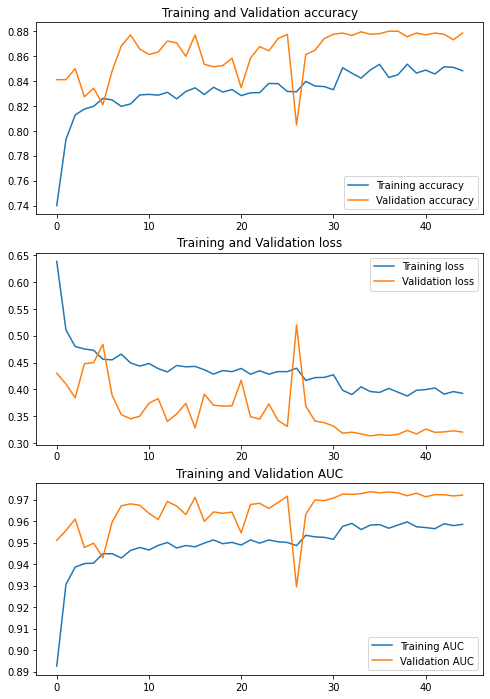

In [8]:
fig, axs = plt.subplots(3, 1, figsize=(8, 12))
plt.subplot(3, 1, 1)
plt.title('Training and Validation accuracy')
plt.plot(history.epoch, history.history['accuracy'], label='Training accuracy')
plt.plot(history.epoch, history.history['val_accuracy'], label='Validation accuracy')
plt.legend()

plt.subplot(3, 1, 2)
plt.title('Training and Validation loss')
plt.plot(history.epoch, history.history['loss'], label='Training loss')
plt.plot(history.epoch, history.history['val_loss'], label='Validation loss')
plt.legend()

plt.subplot(3, 1, 3)
plt.title('Training and Validation AUC')
plt.plot(history.epoch, history.history['AUC'], label='Training AUC')
plt.plot(history.epoch, history.history['val_AUC'], label='Validation AUC')
plt.legend()

plt.show()

In [9]:
import pandas as pd
hist_df = pd.DataFrame(history.history) 
hist_df.index.name='epoch'
hist_df.sort_values(by=['val_loss'],ascending=True)

,loss,accuracy,AUC,precision,recall,val_loss,val_accuracy,val_AUC,val_precision,val_recall,lr
epoch,,,,,,,,,,,
34,0.395866,0.848850,0.958159,0.866166,0.833625,0.313203,0.877461,0.973699,0.891371,0.864173,0.0001
36,0.401719,0.842826,0.956700,0.856867,0.826835,0.314102,0.879921,0.973567,0.893855,0.866142,0.0001
35,0.394239,0.853341,0.958384,0.867235,0.836364,0.315403,0.877953,0.973135,0.888945,0.866634,0.0001
37,0.394666,0.845016,0.958195,0.858587,0.827930,0.316008,0.879921,0.973108,0.889843,0.866634,0.0001
39,0.398215,0.846331,0.957379,0.859669,0.830668,0.316644,0.878445,0.972968,0.890577,0.865157,0.0001
33,0.404726,0.842278,0.956081,0.858267,0.824425,0.316852,0.879429,0.972763,0.891755,0.867618,0.0001
31,0.398170,0.850602,0.957563,0.863559,0.838116,0.318036,0.878445,0.972574,0.888665,0.868110,0.0001
41,0.402589,0.845564,0.956483,0.862828,0.828806,0.319801,0.878445,0.972317,0.888664,0.864173,0.0001
32,0.390310,0.846221,0.958942,0.861971,0.829682,0.320047,0.876476,0.972421,0.890182,0.865650,0.0001


#### Fine-tune SqueezeNet Model

In [10]:
# Get number of layers in the base_model
print("Number of layers in the base model: ", len(base_model.layers))
for layer in base_model.layers:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

squeezenet_model.summary()

Number of layers in the base model:  67
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 111, 111, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 relu_conv1 (Activation)        (None, 111, 111, 64  0           ['conv1[0][0]']                  
                                )                     

In [11]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
squeezenet_model.compile(
    optimizer=adam_optimizer,
    loss="categorical_crossentropy",
    metrics=["accuracy",
             tf.keras.metrics.AUC(name='AUC'),
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')],
)

In [12]:
history_finetune = squeezenet_model.fit(train_generator,
                            epochs=60,
                            validation_data=validation_generator,
                            verbose=1,
                            initial_epoch=history.epoch[-1],
                            callbacks=[reducelr, earlystop,checkpoint,lambdacb])

Beginning training
Learning rate:  1e-04
Epoch 45/60
286/286 [==============================] - ETA: 0s - loss: 0.3613 - accuracy: 0.8628 - AUC: 0.9655 - precision: 0.8741 - recall: 0.8510
Epoch 00045: val_loss improved from 0.31320 to 0.30705, saving model to ./weights/squeezenet_oversample.hdf5
End of epoch 44. Learning rate: 1e-04
286/286 [==============================] - 105s 360ms/step - loss: 0.3613 - accuracy: 0.8628 - AUC: 0.9655 - precision: 0.8741 - recall: 0.8510 - val_loss: 0.3070 - val_accuracy: 0.8834 - val_AUC: 0.9758 - val_precision: 0.8883 - val_recall: 0.8765 - lr: 1.0000e-04
Learning rate:  1e-04
Epoch 46/60
286/286 [==============================] - ETA: 0s - loss: 0.2739 - accuracy: 0.8993 - AUC: 0.9791 - precision: 0.9070 - recall: 0.8921
Epoch 00046: val_loss did not improve from 0.30705
End of epoch 45. Learning rate: 1e-04
286/286 [==============================] - 102s 357ms/step - loss: 0.2739 - accuracy: 0.8993 - AUC: 0.9791 - precision: 0.9070 - recall: 0.

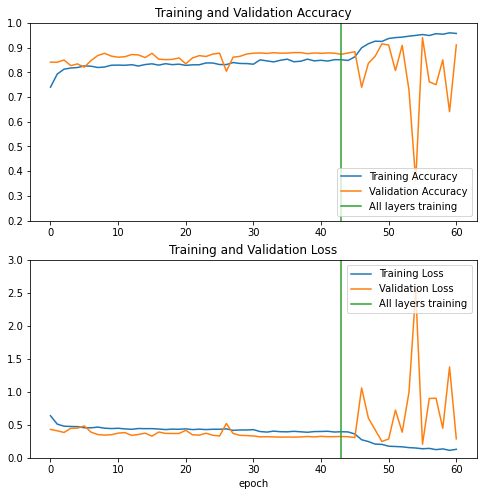

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
initial_epochs=history.epoch[-1]

acc += history_finetune.history['accuracy']
val_acc += history_finetune.history['val_accuracy']
loss += history_finetune.history['loss']
val_loss += history_finetune.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.2, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='All layers training')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 3.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='All layers training')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [14]:
hist_df = pd.DataFrame(history_finetune.history) 
hist_df.index.name='epoch'
hist_df.sort_values(by=['val_loss'],ascending=True)

,loss,accuracy,AUC,precision,recall,val_loss,val_accuracy,val_AUC,val_precision,val_recall,lr
epoch,,,,,,,,,,,
10,0.137169,0.952902,0.993855,0.956167,0.950931,0.206687,0.940453,0.988940,0.941350,0.939961,0.0001
4,0.203326,0.925082,0.988055,0.930320,0.919825,0.247203,0.915354,0.983389,0.920239,0.908465,0.0001
5,0.175594,0.937021,0.990663,0.940676,0.932640,0.285710,0.910433,0.979815,0.913452,0.908957,0.0001
15,0.128827,0.957393,0.994411,0.959850,0.955750,0.287210,0.910925,0.978089,0.913237,0.906496,0.0001
0,0.361296,0.862760,0.965496,0.874114,0.851041,0.307048,0.883366,0.975770,0.888279,0.876476,0.0001
7,0.166474,0.942607,0.991155,0.946706,0.939759,0.388589,0.909449,0.965358,0.911386,0.906004,0.0001
3,0.207813,0.926177,0.987457,0.932579,0.921139,0.424844,0.865157,0.962275,0.871450,0.860728,0.0001
13,0.135355,0.954217,0.994186,0.956732,0.951807,0.448979,0.850394,0.955656,0.857286,0.842520,0.0001
2,0.246548,0.915772,0.982826,0.921318,0.909310,0.602372,0.836614,0.934362,0.844344,0.830217,0.0001


In [17]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
squeezenet_model.compile(
    optimizer=adam_optimizer,
    loss="categorical_crossentropy",
    metrics=["accuracy",
             tf.keras.metrics.AUC(name='AUC'),
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')],
)

history_finetune2 = squeezenet_model.fit(train_generator,
                            epochs=75,
                            validation_data=validation_generator,
                            verbose=1,
                            initial_epoch=history_finetune.epoch[-1],
                            callbacks=[reducelr, earlystop,checkpoint,lambdacb])

Beginning training
Learning rate:  1e-05
Epoch 60/75
286/286 [==============================] - ETA: 0s - loss: 0.0853 - accuracy: 0.9692 - AUC: 0.9974 - precision: 0.9711 - recall: 0.9675
Epoch 00060: val_loss did not improve from 0.20669
End of epoch 59. Learning rate: 1e-05
286/286 [==============================] - 110s 378ms/step - loss: 0.0853 - accuracy: 0.9692 - AUC: 0.9974 - precision: 0.9711 - recall: 0.9675 - val_loss: 0.3233 - val_accuracy: 0.8976 - val_AUC: 0.9729 - val_precision: 0.9029 - val_recall: 0.8922 - lr: 1.0000e-05
Learning rate:  1e-05
Epoch 61/75
286/286 [==============================] - ETA: 0s - loss: 0.0868 - accuracy: 0.9693 - AUC: 0.9971 - precision: 0.9716 - recall: 0.9681
Epoch 00061: val_loss did not improve from 0.20669
End of epoch 60. Learning rate: 1e-05
286/286 [==============================] - 110s 382ms/step - loss: 0.0868 - accuracy: 0.9693 - AUC: 0.9971 - precision: 0.9716 - recall: 0.9681 - val_loss: 0.3517 - val_accuracy: 0.8873 - val_AUC: 

#### Test Image Generation for prediction

In [21]:
model =  tf.keras.models.load_model('./weights/squeezenet_oversample.hdf5')

In [22]:
TEST_IMAGE_FOLDER = '/home/TBX11K/test/Shenzhen'
test_generator = test_datagen.flow_from_directory(
        TEST_IMAGE_FOLDER,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=False,
        class_mode=CLASS_MODE)

res = model.predict(test_generator)

Found 331 images belonging to 3 classes.


#### Evaluate Model

In [23]:
from sklearn.metrics import classification_report
predicted = np.argmax(res, axis=1)
report = classification_report(test_generator.classes, predicted)
print(report)

              precision    recall  f1-score   support

           0       0.94      0.30      0.46       163
           1       0.00      0.00      0.00         0
           2       0.59      0.98      0.74       168

    accuracy                           0.65       331
   macro avg       0.51      0.43      0.40       331
weighted avg       0.77      0.65      0.60       331

